In [1]:
import os
import sys
import glob

sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime

import open3d as o3d
from utilities import convert_to_left_shoulder_coord
import time

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from csv_writer import fusion_csv_columns_name
import matplotlib.pyplot as plt

import joblib
import sklearn

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder",
    "right hip", "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", 
    "THUMB_TIP", "INDEX_FINGER_MCP", "INDEX_FINGER_PIP", "INDEX_FINGER_DIP",
    "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP",
    "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", "RING_FINGER_PIP", "RING_FINGER_DIP",
    "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", "PINKY_DIP", "PINKY_TIP", "right elbow",
    "RIGHT_WRIST", "RIGHT_THUMB_CMC", "RIGHT_THUMB_MCP", "RIGHT_THUMB_IP", "RIGHT_THUMB_TIP",
    "RIGHT_INDEX_FINGER_MCP", "RIGHT_INDEX_FINGER_PIP", "RIGHT_INDEX_FINGER_DIP",
    "RIGHT_INDEX_FINGER_TIP", "RIGHT_MIDDLE_FINGER_MCP", "RIGHT_MIDDLE_FINGER_PIP",
    "RIGHT_MIDDLE_FINGER_DIP", "RIGHT_MIDDLE_FINGER_TIP", "RIGHT_RING_FINGER_MCP",
    "RIGHT_RING_FINGER_PIP", "RIGHT_RING_FINGER_DIP", "RIGHT_RING_FINGER_TIP",
    "RIGHT_PINKY_MCP", "RIGHT_PINKY_PIP", "RIGHT_PINKY_DIP", "RIGHT_PINKY_TIP"]

In [ ]:
PHASE = "train"
DATA_DIR = "/home/giakhang/dev/pose_sandbox/data"  
SELECTED_DATE = "2024-*"  # Keep '*' when using glob.glob

train_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, PHASE)))

body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
train_body_distance_thres = 550
train_leftarm_distance_thres = 550
train_lefthand_distance_thres = 200

train_dataset = HandArmLandmarksDataset_ANN(train_paths, 
    arm_hand_fused_names,
    body_lines, 
    lefthand_lines, 
    train_body_distance_thres, 
    train_leftarm_distance_thres, 
    train_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True,
    cvt_normalized_xy_to_XY=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

KeyError: 'frame_width'

In [8]:
train_dataset._inputs.shape

(1533, 288)

In [5]:
DATA_DIR = "/home/giakhang/dev/pose_sandbox/data"  
SELECTED_DATE = "2024-*"  # Keep '*' when using glob.glob

train_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "train")))
val_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "val")))

#fake_train_paths = glob.glob(os.path.join(DATA_DIR, "fake_data", "train", "fake_*.csv"))

#if len(fake_train_paths) > 0:
    #train_paths.extend(fake_train_paths)

body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
train_body_distance_thres = 550
train_leftarm_distance_thres = 550
train_lefthand_distance_thres = 200
val_body_distance_thres = 450
val_leftarm_distance_thres = 450
val_lefthand_distance_thres = 150

train_dataset = HandArmLandmarksDataset_ANN(train_paths, 
    arm_hand_fused_names,
    body_lines, 
    lefthand_lines, 
    train_body_distance_thres, 
    train_leftarm_distance_thres, 
    train_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True,
    cvt_normalized_xy_to_XY=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataset = HandArmLandmarksDataset_ANN(val_paths,
    arm_hand_fused_names,
    body_lines,
    lefthand_lines,
    val_body_distance_thres,
    val_leftarm_distance_thres,
    val_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True,
    cvt_normalized_xy_to_XY=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)  

In [6]:
train_dataset._outputs.shape

(13400, 144)

In [7]:
train_dataset._inputs.shape

(13400, 288)

In [7]:
val_dataset._outputs.shape

(2379, 144)

In [6]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder", "right hip", 
 "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP", "right elbow"]

In [7]:
target_output = train_dataset._outputs  # shape: (N, 144)
time_sleep = .1
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_left_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()

KeyboardInterrupt: 

In [ ]:
target_output = train_dataset._outputs  #  shape: (N, 144)
sample = target_output[0]  # shape: (144)
sample = sample.reshape(3, 48)  # shape: (3, 48)
sample = sample.T  # shape: (48, 3)
sample = sample[:26]  # shape: (26, 3)

In [ ]:
body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
lines = body_lines.copy()
lines.extend(lefthand_lines)

In [ ]:
points, original_xyz = convert_to_left_shoulder_coord(sample, arm_hand_fused_names)

min_x, min_y, min_z = np.min(points, axis=0)
max_x, max_y, max_z = np.max(points, axis=0)

In [ ]:
vertices = [
    [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
    [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
]

# Define the edges of the bounding box (12 edges for a cuboid)
edges = [
    [0, 1], [1, 3], [3, 2], [2, 0],  # Bottom square
    [4, 5], [5, 7], [7, 6], [6, 4],  # Top square
    [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical lines connecting bottom and top squares
]

# Create a LineSet object for the bounding box
bounding_box = o3d.geometry.LineSet()
bounding_box.points = o3d.utility.Vector3dVector(vertices)
bounding_box.lines = o3d.utility.Vector2iVector(edges)

bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  # Green color for all edges
bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

In [ ]:
colors = [[0, 0, 0] for i in range(len(lines))]

x_unit, y_unit, z_unit = original_xyz[:, 0], original_xyz[:, 1], original_xyz[:, 2]
points = np.concatenate([points, [x_unit * 40, y_unit * 40, z_unit * 40]], axis=0)
last_index = points.shape[0] - 1
lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd, line_set, bounding_box], 
    window_name='Open3D Point Cloud Visualization', width=800, height=600)

In [ ]:
vertices = np.array(vertices)
vertices.shape

(8, 3)

In [ ]:
input_data = train_dataset._inputs

left_camera_first_intrinsic_value_idx = 144
right_camera_first_lmk_value_idx = left_camera_first_intrinsic_value_idx + 9
right_camera_first_intrinsic_value_idx = right_camera_first_lmk_value_idx + 144
first_right_2_left_matrix_value_idx = right_camera_first_intrinsic_value_idx + 9

left_camera_lmks = input_data[:, :left_camera_first_intrinsic_value_idx]  # shape: (N, 144), N = #rows
left_camera_intrinsic = input_data[:, left_camera_first_intrinsic_value_idx:right_camera_first_lmk_value_idx]  # shape: (N, 9), N = #rows
right_camera_lmks = input_data[:, right_camera_first_lmk_value_idx:right_camera_first_intrinsic_value_idx]  # shape: (N, 144), N = #rows
right_camera_intrinsic = input_data[:, right_camera_first_intrinsic_value_idx:first_right_2_left_matrix_value_idx]  # shape: (N, 9), N = #rows
right_2_left_mat = input_data[:, first_right_2_left_matrix_value_idx:]  # shape: (N, 16), N = #rows

In [ ]:
left_camera_lmks = left_camera_lmks.reshape(-1, 3, 48)  # shape: (N, 3, 48)
right_camera_lmks = right_camera_lmks.reshape(-1, 3, 48)  # shape: (N, 3, 48)

In [ ]:
input_data.shape

(1562, 322)

In [ ]:
df = pd.DataFrame(input_data, columns=fusion_csv_columns_name[1:323])

In [ ]:
left_lmks_x = df.loc[:, "left_shoulder_cam_left_x":"right_pinky_tip_cam_left_x"].describe()
left_lmks_y = df.loc[:, "left_shoulder_cam_left_y":"right_pinky_tip_cam_left_y"].describe()
left_lmks_z = df.loc[:, "left_shoulder_cam_left_z":"right_pinky_tip_cam_left_z"].describe()

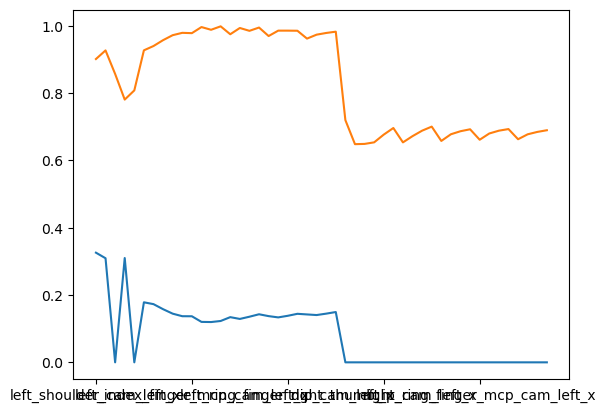

In [ ]:
left_lmks_x.iloc[3, :].plot()
left_lmks_x.iloc[-1, :].plot()

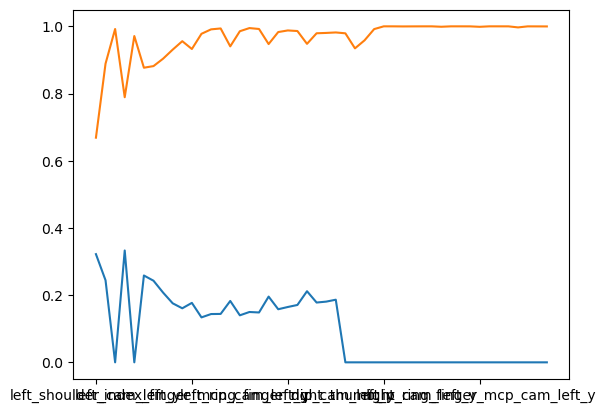

In [ ]:
left_lmks_y.iloc[3, :].plot()
left_lmks_y.iloc[-1, :].plot()

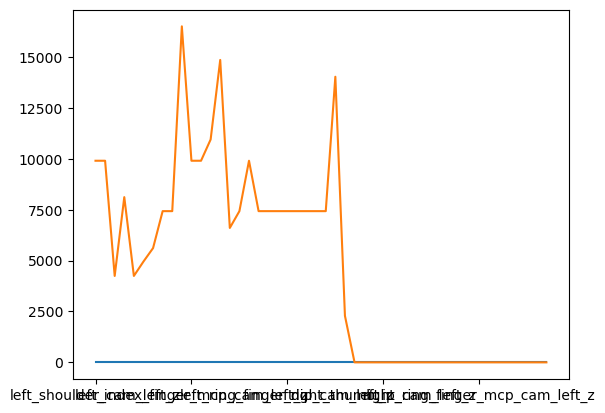

In [ ]:
left_lmks_z.iloc[3, :].plot()
left_lmks_z.iloc[-1, :].plot()

In [ ]:
right_lmks_x = df.loc[:, "left_shoulder_cam_right_x":"right_pinky_tip_cam_right_x"].describe()
right_lmks_y = df.loc[:, "left_shoulder_cam_right_y":"right_pinky_tip_cam_right_y"].describe()
right_lmks_z = df.loc[:, "left_shoulder_cam_right_z":"right_pinky_tip_cam_right_z"].describe()

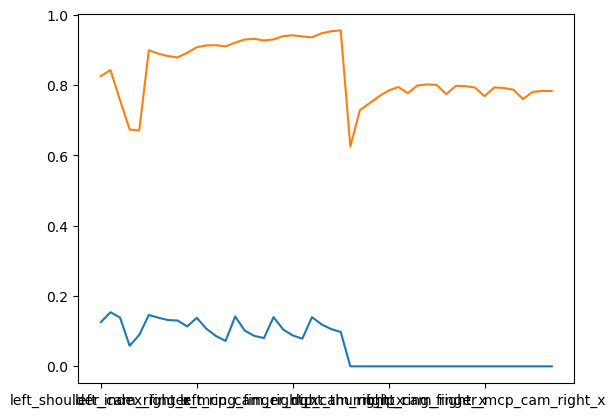

In [ ]:
right_lmks_x.iloc[3, :].plot()
right_lmks_x.iloc[-1, :].plot()

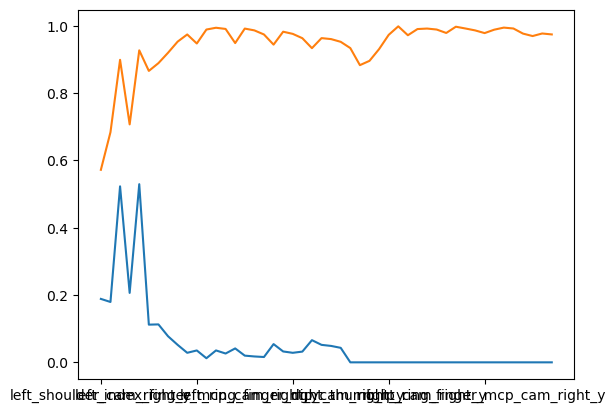

In [ ]:
right_lmks_y.iloc[3, :].plot()
right_lmks_y.iloc[-1, :].plot()

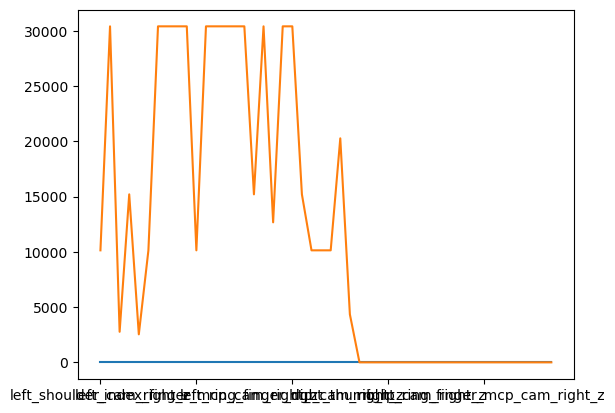

In [ ]:
right_lmks_z.iloc[3, :].plot()
right_lmks_z.iloc[-1, :].plot()

In [ ]:
left_intr = df.loc[:, "left_camera_intrinsic_x11":"left_camera_intrinsic_x33"]
right_intr = df.loc[:, "right_camera_intrinsic_x11":"right_camera_intrinsic_x33"]
trans_mat = df.loc[:, "right_to_left_matrix_x11":"right_to_left_matrix_x44"]

In [ ]:
left_intr.describe()

,left_camera_intrinsic_x11,left_camera_intrinsic_x12,left_camera_intrinsic_x13,left_camera_intrinsic_x21,left_camera_intrinsic_x22,left_camera_intrinsic_x23,left_camera_intrinsic_x31,left_camera_intrinsic_x32,left_camera_intrinsic_x33
count,1562.000000,1562.0,1562.000000,1562.0,1562.000000,1562.000000,1562.0,1562.0,1562.0
mean,4598.874791,0.0,959.456457,0.0,3751.211465,538.132510,0.0,0.0,1.0
std,3466.714168,0.0,24.612530,0.0,2462.042119,7.895210,0.0,0.0,0.0
min,1563.442199,0.0,918.869942,0.0,1546.426224,528.651557,0.0,0.0,1.0
25%,2263.522565,0.0,938.065291,0.0,2414.515204,534.817587,0.0,0.0,1.0
50%,3490.437809,0.0,959.303306,0.0,2535.911793,535.885168,0.0,0.0,1.0
75%,4907.507495,0.0,978.820124,0.0,4960.791703,542.520388,0.0,0.0,1.0
max,12465.472432,0.0,992.764689,0.0,12731.814253,577.957066,0.0,0.0,1.0


In [ ]:
right_intr.describe()

,right_camera_intrinsic_x11,right_camera_intrinsic_x12,right_camera_intrinsic_x13,right_camera_intrinsic_x21,right_camera_intrinsic_x22,right_camera_intrinsic_x23,right_camera_intrinsic_x31,right_camera_intrinsic_x32,right_camera_intrinsic_x33
count,1562.000000,1562.0,1562.000000,1562.0,1562.000000,1562.000000,1562.0,1562.0,1562.0
mean,2602.129983,0.0,984.293126,0.0,1984.533611,547.439440,0.0,0.0,1.0
std,924.519685,0.0,20.035861,0.0,321.529009,10.197533,0.0,0.0,0.0
min,1627.383636,0.0,957.009185,0.0,1610.743029,533.765713,0.0,0.0,1.0
25%,1667.582961,0.0,971.768453,0.0,1670.126165,538.404560,0.0,0.0,1.0
50%,2609.448703,0.0,973.039593,0.0,2123.205366,543.767867,0.0,0.0,1.0
75%,3557.576515,0.0,1003.108998,0.0,2244.339612,550.374463,0.0,0.0,1.0
max,4228.961452,0.0,1018.203584,0.0,2997.006359,562.858548,0.0,0.0,1.0


In [ ]:
trans_mat.describe()

,right_to_left_matrix_x11,right_to_left_matrix_x12,right_to_left_matrix_x13,right_to_left_matrix_x14,right_to_left_matrix_x21,right_to_left_matrix_x22,right_to_left_matrix_x23,right_to_left_matrix_x24,right_to_left_matrix_x31,right_to_left_matrix_x32,right_to_left_matrix_x33,right_to_left_matrix_x34,right_to_left_matrix_x41,right_to_left_matrix_x42,right_to_left_matrix_x43,right_to_left_matrix_x44
count,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.0,1562.0,1562.0,1562.0
mean,0.254124,-0.056011,0.700118,-1125.888917,0.026153,0.871843,0.051255,45.821586,-0.614856,-0.007351,0.181828,1697.558721,0.0,0.0,0.0,1.0
std,0.584176,0.022363,0.156070,214.196053,0.085092,0.198249,0.065261,74.055894,0.245050,0.113045,0.535346,712.467261,0.0,0.0,0.0,0.0
min,-0.765009,-0.113015,0.452161,-1745.801442,-0.037560,0.320167,-0.198552,-110.004330,-0.956979,-0.134901,-0.764159,129.563701,0.0,0.0,0.0,1.0
25%,-0.276995,-0.060036,0.577298,-1303.451410,-0.016703,0.775209,0.042529,-13.641169,-0.656671,-0.071244,-0.277875,920.971645,0.0,0.0,0.0,1.0
50%,0.655623,-0.053206,0.675583,-1033.889529,0.007743,0.973921,0.079987,47.325136,-0.598997,-0.045949,0.519120,1892.383133,0.0,0.0,0.0,1.0
75%,0.691409,-0.048206,0.771867,-961.990160,0.011454,0.997541,0.084486,67.623207,-0.395518,0.036745,0.634018,2080.701025,0.0,0.0,0.0,1.0
max,0.844444,-0.018432,0.955132,-878.168983,0.265354,0.998619,0.100723,209.860544,-0.082694,0.284573,0.648709,2936.297902,0.0,0.0,0.0,1.0


In [ ]:
columns_to_normalize = ["left_shoulder_cam_left_z",
    "left_elbow_cam_left_z",
    "left_hip_cam_left_z",
    "right_shoulder_cam_left_z",
    "right_hip_cam_left_z",
    "left_wrist_cam_left_z",
    "left_thumb_cmc_cam_left_z",
    "left_thumb_mcp_cam_left_z",
    "left_thumb_ip_cam_left_z",
    "left_thumb_tip_cam_left_z",
    "left_index_finger_mcp_cam_left_z",
    "left_index_finger_pip_cam_left_z",
    "left_index_finger_dip_cam_left_z",
    "left_index_finger_tip_cam_left_z",
    "left_middle_finger_mcp_cam_left_z",
    "left_middle_finger_pip_cam_left_z",
    "left_middle_finger_dip_cam_left_z",
    "left_middle_finger_tip_cam_left_z",
    "left_ring_finger_mcp_cam_left_z",
    "left_ring_finger_pip_cam_left_z",
    "left_ring_finger_dip_cam_left_z",
    "left_ring_finger_tip_cam_left_z",
    "left_pinky_mcp_cam_left_z",
    "left_pinky_pip_cam_left_z",
    "left_pinky_dip_cam_left_z",
    "left_pinky_tip_cam_left_z",
    "right_elbow_cam_left_z",
    "right_wrist_cam_left_z",
    "right_thumb_cmc_cam_left_z",
    "right_thumb_mcp_cam_left_z",
    "right_thumb_ip_cam_left_z",
    "right_thumb_tip_cam_left_z",
    "right_index_finger_mcp_cam_left_z",
    "right_index_finger_pip_cam_left_z",
    "right_index_finger_dip_cam_left_z",
    "right_index_finger_tip_cam_left_z",
    "right_middle_finger_mcp_cam_left_z",
    "right_middle_finger_pip_cam_left_z",
    "right_middle_finger_dip_cam_left_z",
    "right_middle_finger_tip_cam_left_z",
    "right_ring_finger_mcp_cam_left_z",
    "right_ring_finger_pip_cam_left_z",
    "right_ring_finger_dip_cam_left_z",
    "right_ring_finger_tip_cam_left_z",
    "right_pinky_mcp_cam_left_z",
    "right_pinky_pip_cam_left_z",
    "right_pinky_dip_cam_left_z",
    "right_pinky_tip_cam_left_z",
    "left_camera_intrinsic_x11",
    "left_camera_intrinsic_x12",
    "left_camera_intrinsic_x13",
    "left_camera_intrinsic_x21",
    "left_camera_intrinsic_x22",
    "left_camera_intrinsic_x23",
    "left_camera_intrinsic_x31",
    "left_camera_intrinsic_x32",
    "left_camera_intrinsic_x33",
    "left_shoulder_cam_right_z",
    "left_elbow_cam_right_z",
    "left_hip_cam_right_z",
    "right_shoulder_cam_right_z",
    "right_hip_cam_right_z",
    "left_wrist_cam_right_z",
    "left_thumb_cmc_cam_right_z",
    "left_thumb_mcp_cam_right_z",
    "left_thumb_ip_cam_right_z",
    "left_thumb_tip_cam_right_z",
    "left_index_finger_mcp_cam_right_z",
    "left_index_finger_pip_cam_right_z",
    "left_index_finger_dip_cam_right_z",
    "left_index_finger_tip_cam_right_z",
    "left_middle_finger_mcp_cam_right_z",
    "left_middle_finger_pip_cam_right_z",
    "left_middle_finger_dip_cam_right_z",
    "left_middle_finger_tip_cam_right_z",
    "left_ring_finger_mcp_cam_right_z",
    "left_ring_finger_pip_cam_right_z",
    "left_ring_finger_dip_cam_right_z",
    "left_ring_finger_tip_cam_right_z",
    "left_pinky_mcp_cam_right_z",
    "left_pinky_pip_cam_right_z",
    "left_pinky_dip_cam_right_z",
    "left_pinky_tip_cam_right_z",
    "right_elbow_cam_right_z",
    "right_wrist_cam_right_z",
    "right_thumb_cmc_cam_right_z",
    "right_thumb_mcp_cam_right_z",
    "right_thumb_ip_cam_right_z",
    "right_thumb_tip_cam_right_z",
    "right_index_finger_mcp_cam_right_z",
    "right_index_finger_pip_cam_right_z",
    "right_index_finger_dip_cam_right_z",
    "right_index_finger_tip_cam_right_z",
    "right_middle_finger_mcp_cam_right_z",
    "right_middle_finger_pip_cam_right_z",
    "right_middle_finger_dip_cam_right_z",
    "right_middle_finger_tip_cam_right_z",
    "right_ring_finger_mcp_cam_right_z",
    "right_ring_finger_pip_cam_right_z",
    "right_ring_finger_dip_cam_right_z",
    "right_ring_finger_tip_cam_right_z",
    "right_pinky_mcp_cam_right_z",
    "right_pinky_pip_cam_right_z",
    "right_pinky_dip_cam_right_z",
    "right_pinky_tip_cam_right_z",
    "right_camera_intrinsic_x11",
    "right_camera_intrinsic_x12",
    "right_camera_intrinsic_x13",
    "right_camera_intrinsic_x21",
    "right_camera_intrinsic_x22",
    "right_camera_intrinsic_x23",
    "right_camera_intrinsic_x31",
    "right_camera_intrinsic_x32",
    "right_camera_intrinsic_x33",
    "right_to_left_matrix_x11",
    "right_to_left_matrix_x12",
    "right_to_left_matrix_x13",
    "right_to_left_matrix_x14",
    "right_to_left_matrix_x21",
    "right_to_left_matrix_x22",
    "right_to_left_matrix_x23",
    "right_to_left_matrix_x24",
    "right_to_left_matrix_x31",
    "right_to_left_matrix_x32",
    "right_to_left_matrix_x33",
    "right_to_left_matrix_x34",
    "right_to_left_matrix_x41",
    "right_to_left_matrix_x42",
    "right_to_left_matrix_x43",
    "right_to_left_matrix_x44"]

In [ ]:
scaler = MinMaxScaler()

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [ ]:
df.loc[:, "left_shoulder_cam_left_x":"left_elbow_cam_left_x"].values.shape

(1562, 2)

In [ ]:
x = train_dataset._outputs[0]
x = x.reshape(3, 48)[:, :26].T
points, _ = convert_to_left_shoulder_coord(x, arm_hand_fused_names)
lines = body_lines.copy()
lines.extend(lefthand_lines)
colors = [[1, 0, 0] for i in range(len(lines))]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

min_x, min_y, min_z = np.min(points, axis=0)
max_x, max_y, max_z = np.max(points, axis=0)
vertices = [
    [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
    [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
]
vertices = np.array(vertices) 
edges = [
    [0, 1], [1, 3], [3, 2], [2, 0],  
    [4, 5], [5, 7], [7, 6], [6, 4],  
    [0, 4], [1, 5], [2, 6], [3, 7]   
]
bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(vertices),
    lines=o3d.utility.Vector2iVector(edges)
)
bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

o3d.visualization.draw_geometries([pcd, line_set, bounding_box])